# <div align="center" style="font-size: 50px;">Machine Intelligence Exam Part II</div>

### **Instructions**:

- Students are allowed to use any notes and material they want (physical or electronic).
- Students are not allowed to use any online resource.
- Students are not allowed to use any generative AI tool or any automatic code generation.
- Students are allowed to use any IDE they want (e.g., Visual Code, PyCharm).
- The IDE must not have any generative AI tool activated for code generation.
- You need to install, at least, the following packages: ``numpy``, ``matplotlib``, ``pandas``, ``jupyter`` , ``tensorflow``and ``keras``.

# Imports and Data Loading

This code imports essential Python libraries for data manipulation, numerical computing, and visualization, and sets NumPy array print precision to two decimal places for cleaner output.

In [5]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays


This code defines a function `load_data()` that loads the dataset from a CSV file, processes it by removing certain columns, and returns the feature matrix X, target values y, feature names, and index values in a format suitable for machine learning tasks. If loading from the Google Drive URL fails, the function will automatically attempt to load the data from a local file "./Train.csv" which should be placed in the same directory as the notebook.

-----------------------------------------------------

Look at the code of the method `load_data()` to know in which folder you have to place the given file `Data.csv` containing the dataset. Alternatively, modify the code of the method to properly read the file `Data.csv`.

-----------------------------------------------------


In [6]:
import pandas as pd
import numpy as np

def load_data():
    try:
        df = pd.read_csv("./adult.csv", sep=',')
    except FileNotFoundError:
        raise FileNotFoundError("Could not load data from './adult.csv'")

    # Drop an ID / index column if present (Kaggle version has "Unnamed: 0")
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Define target column (adjust name if different in your file)
    target_col = "income"
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in CSV.")

    # Dictionary to store mappings for all categorical columns
    # cat_maps[col_name] = {category_value: numeric_code}
    cat_maps = {}

    # Detect categorical columns (object or pandas 'category' dtype)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Encode each categorical column to integers (including target if it's string)
    for col in cat_cols:
        # Get sorted unique values to have a stable, reproducible mapping
        categories = sorted(df[col].dropna().unique())
        mapping = {cat: i for i, cat in enumerate(categories)}
        df[col] = df[col].map(mapping)
        cat_maps[col] = mapping

    # Now split into features and target
    y = df[target_col].to_numpy().astype('float64')
    X_df = df.drop(columns=[target_col])

    # Features names (after encoding)
    features = list(X_df.columns)

    # Convert to numpy array of floats
    X = X_df.to_numpy().astype('float64')

    # Use row index as an "index" vector (you can adapt if you have a real ID column)
    index = np.arange(len(df))

    rng = np.random.default_rng()
    perm = rng.permutation(len(X))

    X = X[perm]
    y = y[perm]
    index = index[perm]

    return X, y, features, index, cat_maps

# The Predictive Problem


### Description

The Adult Census Income dataset (also known as the *Census Income* dataset) is derived from the 1994 U.S. Census database and contains demographic, educational, and employment-related information about individuals. The dataset is widely used in machine learning research to study classification performance, interpretability, and algorithmic fairness.

Each record represents a single individual and includes attributes such as age, education level, occupation, marital status, working hours, and capital gains or losses. Because it combines numerical and categorical variables drawn from real socio-economic data, the dataset is particularly useful for benchmarking classification models and analyzing how different features contribute to income prediction.

---

### Predictive Task

You are provided with individual-level census records. The objective is to predict whether an individual’s annual income exceeds **50000** USD, based solely on their demographic and employment attributes.

This is a **binary classification** task, where each data point corresponds to one person.

---

### Data Fields

* **age**: Age of the individual (integer).
* **workclass**: Employment type (e.g., Private, Self-emp, Government).
* **fnlwgt**: Final sampling weight assigned by the Census Bureau.
* **education**: Highest level of education attained.
* **education-num**: Numerical encoding of education level.
* **marital-status**: Marital status of the individual.
* **occupation**: Occupation category.
* **relationship**: Relationship status within the household.
* **race**: Self-reported race category.
* **sex**: Biological sex (Male or Female).
* **capital-gain**: Capital gains for the individual.
* **capital-loss**: Capital losses for the individual.
* **hours-per-week**: Average number of hours worked per week.
* **native-country**: Country of origin.
* **income**: The target variable indicating income level:
  - 0 (or `<=50K`): Income at or below 50,000 USD
  - 1 (or `>50K`): Income above 50,000  USD


# 1. Data Exploration and Preprocessing


This code loads the dataset into features (X_train), target values (y_train), feature names (X_features), and index values (index) and categorical to numeric map (cat_maps) using the load_data() function.

In [7]:
# load the dataset
X_train, y_train, X_features, index, cat_maps = load_data()

# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")

X Shape: (48842, 14), X Type:<class 'numpy.ndarray'>)
y Shape: (48842,), y Type:<class 'numpy.ndarray'>)


- The following visualization is organized into different subplots, with each subplot representing the relationship between a specific feature and target variable.

- Each bar in the subplots illustrates the **percentage distribution** between:
  - **<=50K>** (green)
  - **>50K** (red)

- For **numeric features**:
  - The data is **discretized into 4 bins** to improve clarity and make the visualization more interpretable.

- This approach allows for an easy comparison of how different feature values influence the target variable.


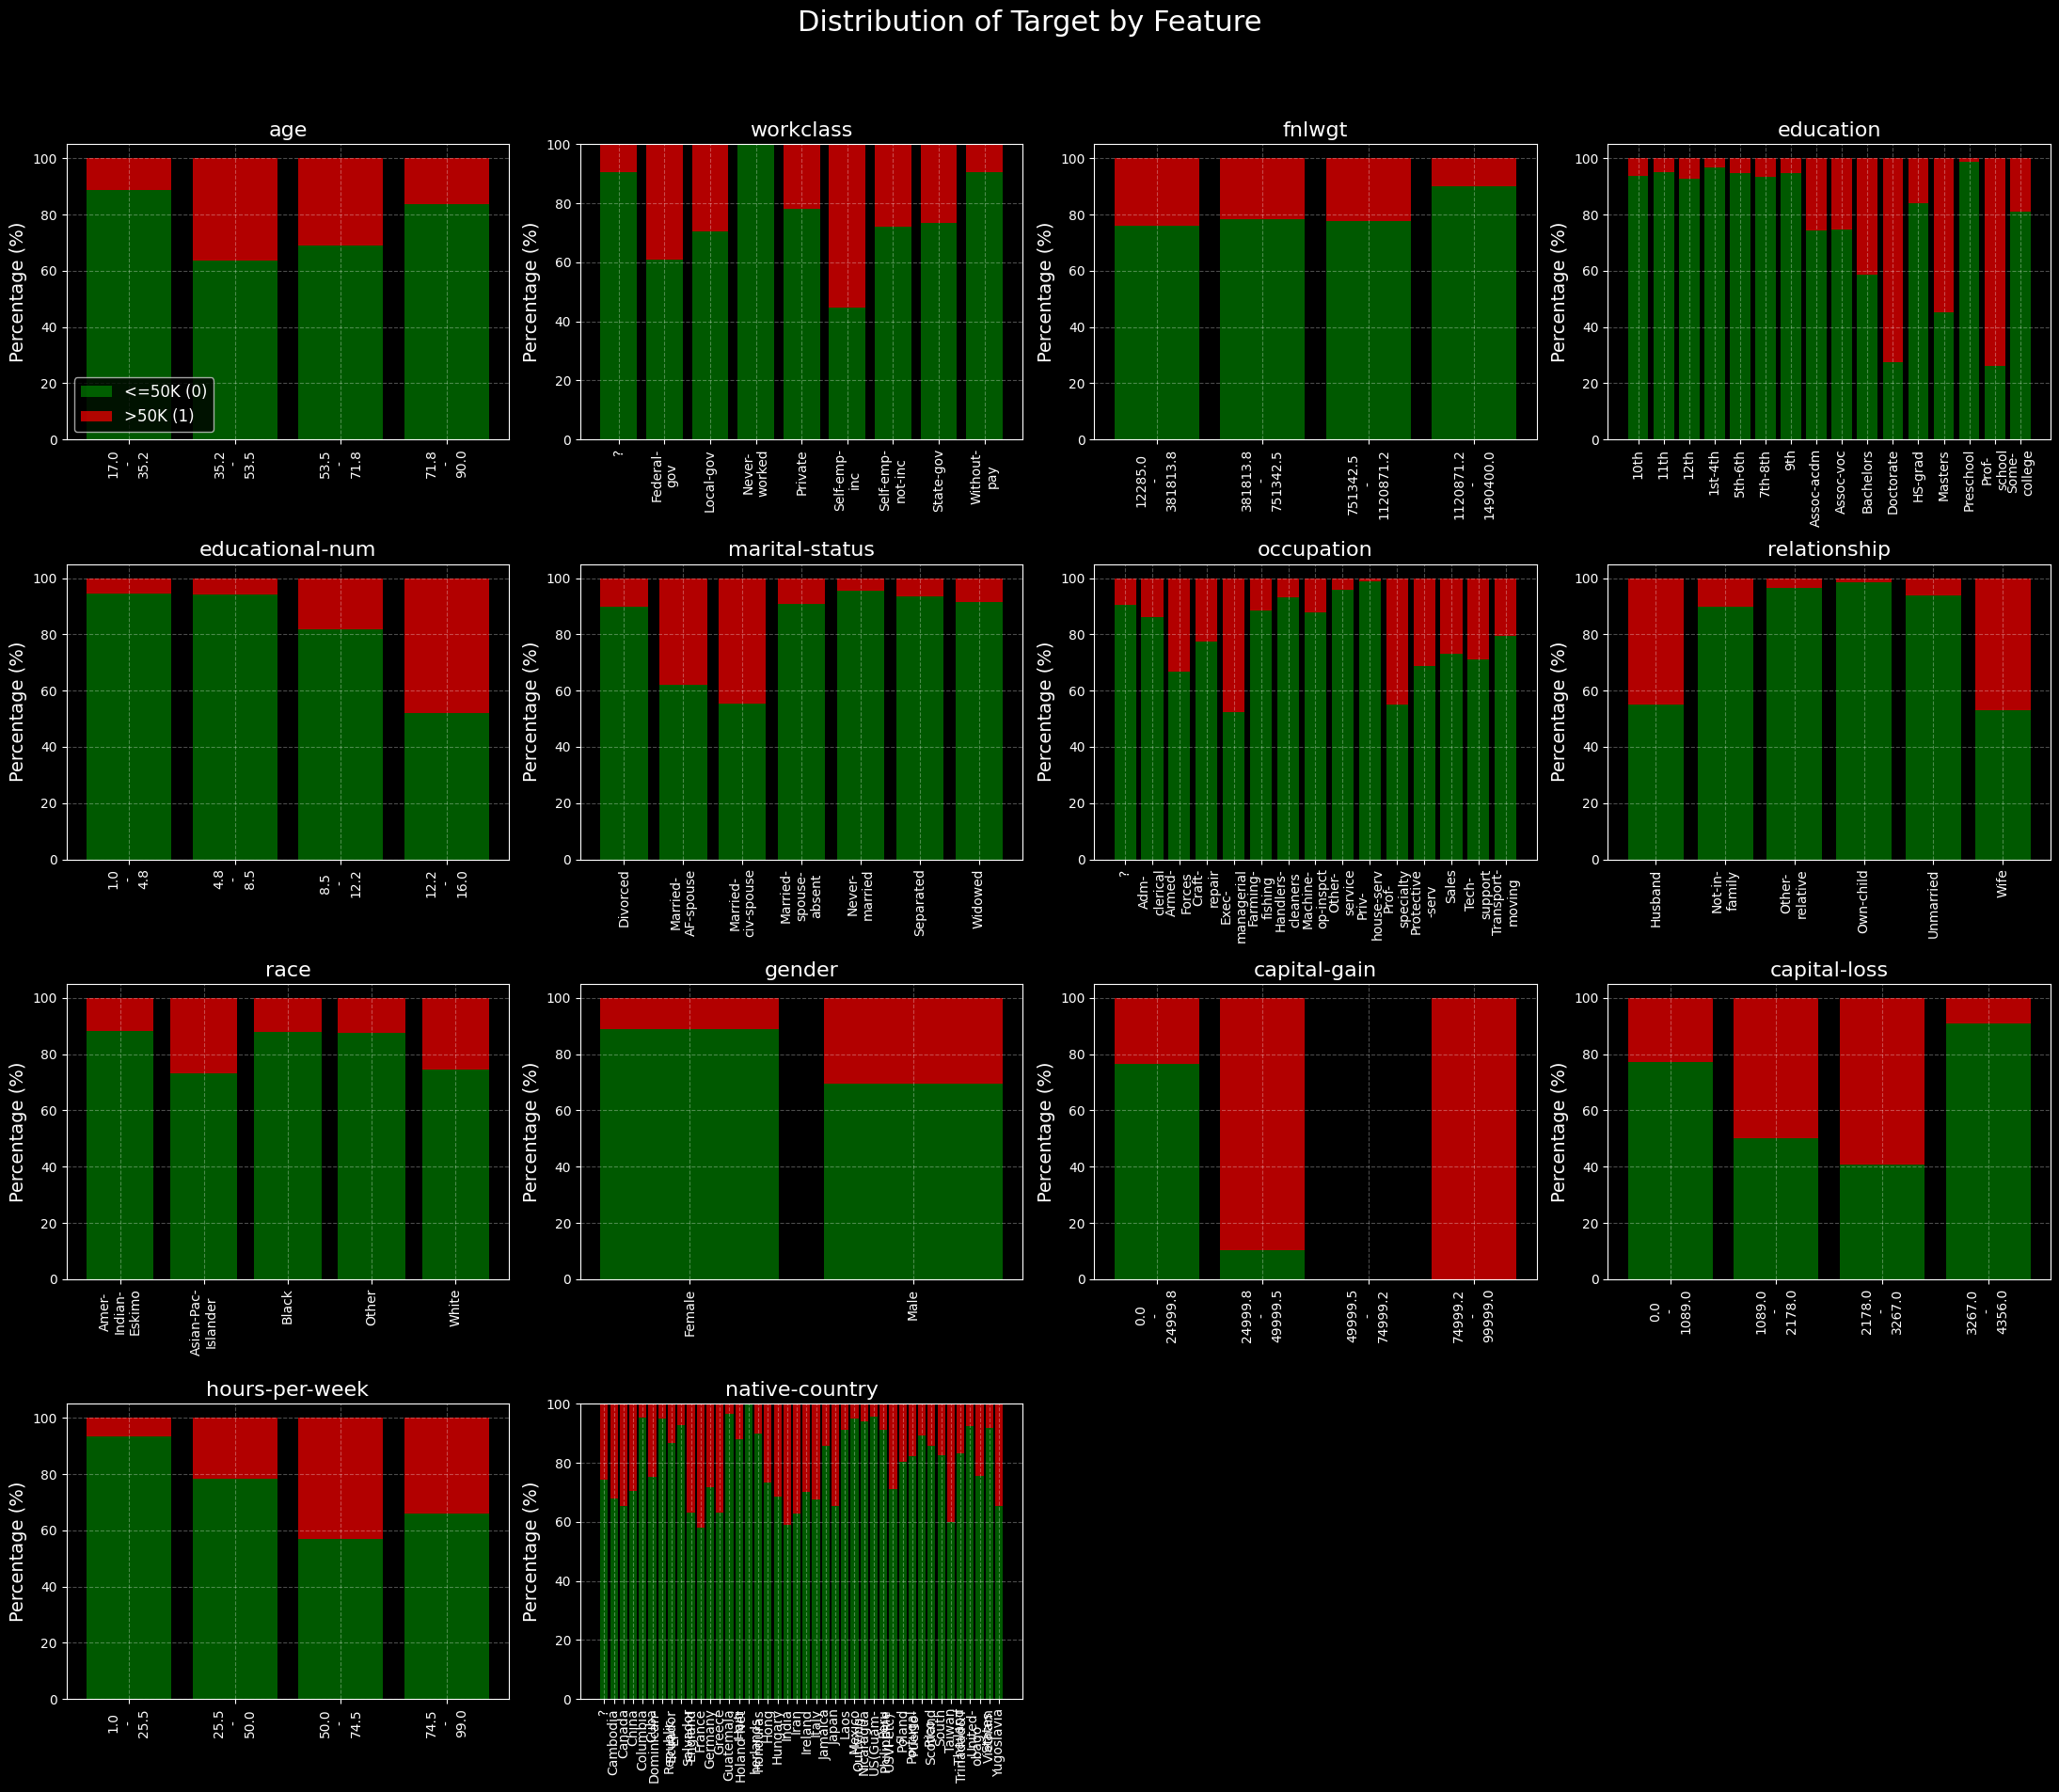

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

def wrap_label(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

def plot_credit_features(X_train, y_train, feature_names, cat_maps):
    n_features = len(feature_names)
    n_rows = int(np.ceil(n_features / 4))
    n_cols = 4

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(22, n_rows * 5))
    fig.suptitle('Distribution of Target by Feature', fontsize=22)
    ax = ax.ravel()

    for i, fname in enumerate(feature_names):
        feature_vals = X_train[:, i]

        # --- Categorical
        if fname in cat_maps:
            mapping = cat_maps[fname]
            inv_map = {v: k for k, v in mapping.items()}
            unique_vals = sorted(inv_map.keys())

            # WRAP LABELS (makes long names readable)
            x_labels = [wrap_label(str(inv_map[val]), width=10) for val in unique_vals]

        # --- Numeric
        else:
            bins = np.linspace(feature_vals.min(), feature_vals.max(), 5)
            feature_vals = np.digitize(feature_vals, bins[1:-1])
            unique_vals = [0,1,2,3]
            x_labels = [
                f"{bins[j]:.1f}\n-\n{bins[j+1]:.1f}"
                for j in range(len(bins)-1)
            ]

        # Compute good/bad %
        good_pct, bad_pct = [], []

        for val in unique_vals:
            mask = (feature_vals == val)
            total = np.sum(mask)
            if total > 0:
                bad = np.sum(y_train[mask] == 1)
                good = np.sum(y_train[mask] == 0)
                bad_pct.append((bad / total) * 100)
                good_pct.append((good / total) * 100)
            else:
                bad_pct.append(0)
                good_pct.append(0)

        ax[i].bar(x_labels, good_pct, label='<=50K (0)', color='green', alpha=0.7)
        ax[i].bar(x_labels, bad_pct, bottom=good_pct, label='>50K (1)', color='red', alpha=0.7)

        ax[i].set_title(fname, fontsize=16)
        ax[i].set_ylabel('Percentage (%)', fontsize=14)
        ax[i].tick_params(axis='x', rotation=90, labelsize=10)  # VERTICAL LABELS
        ax[i].grid(True, linestyle='--', alpha=0.3)

        if i == 0:
            ax[i].legend(fontsize=12)

    # Remove empty subplots
    for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_credit_features(X_train, y_train, X_features, cat_maps)


## TASK 1: Data Analysis

Looking at the figures, choose what you think is the most and least informative feature to predict the target variable. Justify your answer.

Introduce your answer in the cell below.




### Answer (approx 200 words)

The most informative feature is likely education, with the least informative being race.

The justification is that the value distribution is greatest when it comes to the features related to education.
E.g., having a doctorate, master's or professional school degree places your chances to earn >50k at almost 80%, 60% and 80% respectively, while a lower level like preschool has around 5%, which can be seen in the `education` feature.
Furthermore, the `educational-num` shows that a higher value (higher educational level) increases the chances exponentially, with lower education being around 5% and higher education being around 50%.
A greater value domain means that some data points are more significant than others, which is what we want/need.

Race, on the other hand, shows a much smaller distribution.
It is still notable that white and Asian-Pacific islanders have slightly higher chances, but overall the value is consistent to around 10-20% chance to earn >50k regardless of race.
 When values are close to the average throughout the entire dataset, it's difficult or impossible to make any meaningful conclusions about the data.

# 2. Model Defintion



The provided code snippet demonstrates how to build, train, and evaluate a **logistic regression model** using Keras, a popular deep learning library. The model is designed to predict the target variable.

## TASK 2A: Hyperparamter Tuning


When training your logistic regression model using Keras, selecting the right hyperparameters is essential to ensure optimal performance and generalization to unseen data. In this task, you are required to determine suitable values for three key hyperparameters: the **learning rate**, the **number of epochs**, and the **validation split**. Each of these decisions plays a critical role in shaping the training process and the model's final accuracy.

For each hyperparameter, provide a clear rationale for your chosen values. To guide your reasoning, consider the following:

- **Learning Rate**:
  How does your selected learning rate balance the trade-off between model convergence speed and training stability? What potential issues, such as slow convergence or overshooting, could arise with suboptimal values?

- **Number of Epochs**:
  Why is your chosen number of epochs appropriate, given the complexity of your dataset and the risk of overfitting or underfitting? How do you plan to monitor performance during training to refine this choice?

- **Validation Split**:
  How does your chosen validation split ensure a robust and reliable evaluation of your model’s performance during training? What considerations (e.g., dataset size or class balance) influenced this decision?

Provide your reasoning and selected values in the cell below. Be sure to connect your choices to the specifics of your dataset and model to demonstrate a thoughtful approach to hyperparameter tuning.

**If the training takes longer than 2 min consider stop the training and do not explore these configurations.**


We first proceed to normalize the data

In [9]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

# 2. Apply to Train Data
X_train = (X_train - train_mean) / train_std

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5760 - loss: 0.7601 - val_accuracy: 0.7509 - val_loss: 0.5357
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8038 - loss: 0.4671 - val_accuracy: 0.8265 - val_loss: 0.4299
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8294 - loss: 0.4119 - val_accuracy: 0.8279 - val_loss: 0.4037
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8272 - loss: 0.3943 - val_accuracy: 0.8269 - val_loss: 0.3929
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8278 - loss: 0.3862 - val_accuracy: 0.8267 - val_loss: 0.3886
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8258 - loss: 0.3826 - val_accuracy: 0.8258 - val_loss: 0.3863
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8256 - loss: 0.3813 - val_accuracy: 0.8252 - val_loss: 0.3856
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8260 - loss: 0.3802 - val_accuracy: 0.8256 - val_l

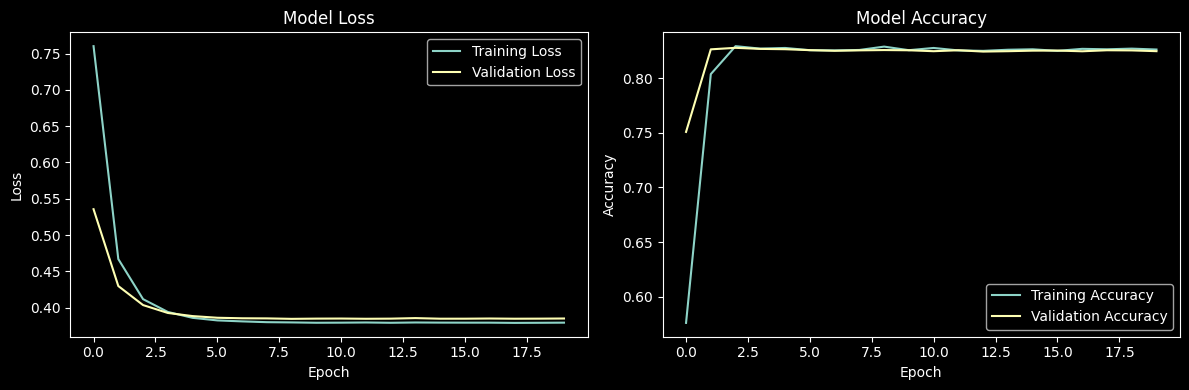

Final Training Loss: 0.3795
Final Training Accuracy: 0.8264
Final Validation Loss: 0.3852
Final Validation Accuracy: 0.8249


In [43]:
# Import necessary libraries from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))  # Logistic regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=20,
                   batch_size=100,
                   validation_split=0.9,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer (approx 300 words)

**Learning rate**: A low learning rate means that convergence only happens very slowly as the model has to make small steps towards the optimal value, while a high learning rate means that large steps are taken during convergence.
This can result in models that overshoot and never really "hit" the optimal value.
The learning rate can be compared to the sampling size in audio processing or pixel density in digital photos: Low values give bad results, while high values take too much time or memory.
So the learning rate needs to be kept small, but not so small that the steps are "tiny" and the model takes forever to advance in significant steps.

**Epochs**: The number of cycles the model takes for learning.
A lower epoch number means that the model has to finish learning faster, while a higher number means the model takes longer to learn.
The number of epochs can be adjusted by monitoring the model loss and accuracy.
If the two named values converge rather early, let us say, after 10 cycles, there is no need to run 1000 cycles.
In that case, the epoch number can be lowered to a safe upper bound like 20.
If the number is too low, the model might never finish learning accurately and simply return a garbage value.
I chose 20 epochs because the model converges after around 5 cycles, but the additional epochs are a safe upper bound.

**Learning rate and epochs**: I could have chosen a significantly lower learning rate (more accuracy), but then I would have to increase the number of epochs, to offset for the learning rate "slowness."

**Validation split**: This number decides how much of the available dataset the model uses for training.
If we assume a large dataset with an underpowered computer, we would probably need to "throw away" more data to be able to process the dataset within a meaningful timeframe.
On the other hand, small datasets with high processing power can use models that use the entire data.

## TASK 2B: Regularization

Regularization is a key technique in machine learning that prevents overfitting by adding a penalty to the loss function. Here you will explore how regularization affects the performance of a logistic regression model on the dataset.

1. Train a logistic regression models using Keras and L2 regularization.
* Use the Dense layer in Keras with the `kernel_regularizer` parameter to apply the regularization.
* Experiment with different values of the regularization strength and note their impact.

2. Evaluate the Models:

* Compare the performance of both models using accuracy and validation loss.

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5647 - loss: 0.7181 - val_accuracy: 0.7610 - val_loss: 0.5318
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7998 - loss: 0.4767 - val_accuracy: 0.8193 - val_loss: 0.4409
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8229 - loss: 0.4204 - val_accuracy: 0.8246 - val_loss: 0.4099
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8264 - loss: 0.3993 - val_accuracy: 0.8252 - val_loss: 0.3968
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8251 - loss: 0.3894 - val_accuracy: 0.8250 - val_loss: 0.3911
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8245 - loss: 0.3849 - val_accuracy: 0.8244 - val_loss: 0.3880
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8251 - loss: 0.3823 - val_accuracy: 0.8253 - val_loss: 0.3867
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8260 - loss: 0.3814 - val_accuracy: 0.8248 - val_loss:

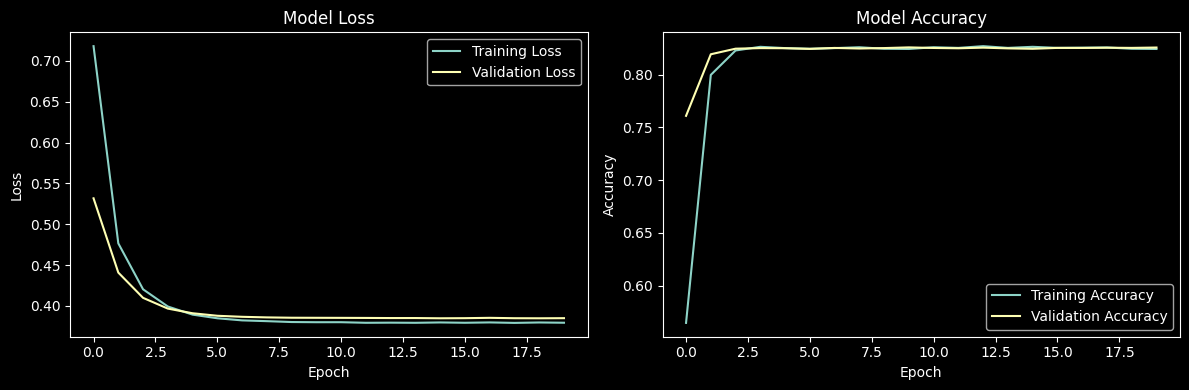

Final Training Loss: 0.3794
Final Training Accuracy: 0.8243
Final Validation Loss: 0.3850
Final Validation Accuracy: 0.8257


In [48]:
# Import necessary libraries from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers

# Define the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_regularizer=regularizers.L2(0.0), activation='sigmoid'))  # Logistic regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=20,
                   batch_size=100,
                   validation_split=0.9,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer

Real world datasets are not perfect, i.e., outlier values can occur.
In such cases, the model can return false positives/negatives, i.e., learn and classify the data wrongly, if it takes the outliers into account too much.
After all, we are only interested in getting a generalized picture of the data, not taking every data point into account, only the most significant.
This problem is amplified by large datasets with many outliers.

Regularization adds a penalty to the model's loss/cost function, meaning that greater loss values will be taken less into consideration in the calculation.

 2. Discuss how the regularization terms affected the models in terms of overfitting and underfitting. (200 words)

Overfitting can happen when the model "learns to well," capturing the insignificant outlier data into the model.
When we use regularization, we can remove this "noise" from the model, using the regularization method described above.

## TASK 2C: Creating A Multi-Layer Perceptron

Now that you have gained experience training models, your next task is to create a **multilayer perceptron (MLP)** using Keras and train it as you did in previous exercises. Follow the steps below to guide your experimentation:

- **Create and Experiment with Different Architectures**:
  - Vary the **number of layers**.
  - Adjust the **number of neurons in each layer (width)** .
  - Use **different activation functions**.

-  **Train the MLP with L2 regularization**.
   - Use the Dense layer in Keras with the kernel_regularizer parameter to apply the regularization.
   - Experiment with different values of the regularization strength and note their impact.

- **Train and Evaluate**:
  - Train each configuration and monitor the key metrics (e.g., accuracy, loss) to compare different configurations.

- **Analyze and Discuss**:
  - Discuss your findings and justify which one would be the best configuration for this dataset and problem.


**If the training takes longer than 2 min consider stop the training and do not explore these configurations.**


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5035 - loss: 0.8570 - val_accuracy: 0.5130 - val_loss: 0.8240
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5321 - loss: 0.7855 - val_accuracy: 0.5425 - val_loss: 0.7570
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5676 - loss: 0.7244 - val_accuracy: 0.5769 - val_loss: 0.7000
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6016 - loss: 0.6726 - val_accuracy: 0.6123 - val_loss: 0.6526
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6398 - loss: 0.6298 - val_accuracy: 0.6492 - val_loss: 0.6129
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6669 - loss: 0.5942 - val_accuracy: 0.6833 - val_loss: 0.5806
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6966 - loss: 0.5651 - val_accuracy: 0.7158 - val_loss: 0.5539
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7260 - loss: 0.5409 - val_accuracy: 0.7414 - val_loss:

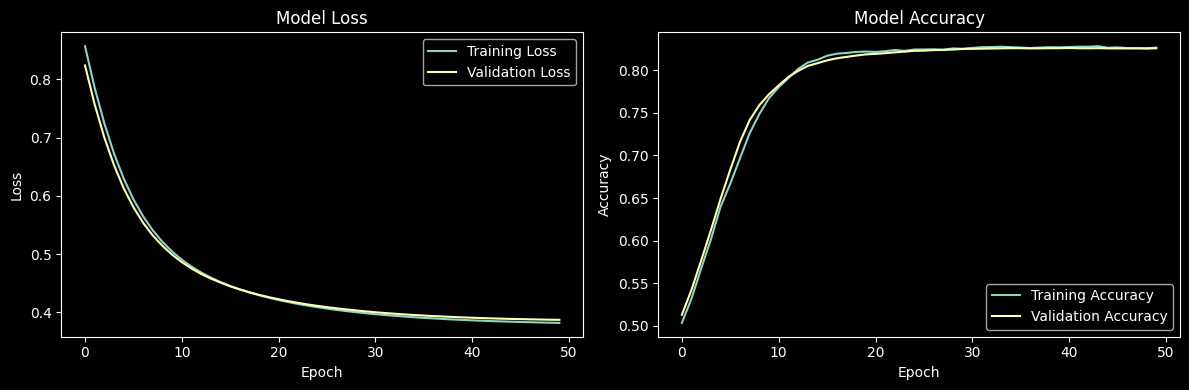

Final Training Loss: 0.3820
Final Training Accuracy: 0.8266
Final Validation Loss: 0.3872
Final Validation Accuracy: 0.8257


In [53]:
#Introduce the code for the MLP here
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=100,
                   validation_split=0.9,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer (300 words)

[Introduce your answer here]



------

# Task 3. Discussion of Key Take-aways
In this section, you are expected to articulate the most relevant insights gained throughout the workflow. Use precise terminology consistent with the course material and ensure that your discussion explicitly connects to concepts introduced in the lectures and exercises.

## 3a. Dataset Take-aways (approx. 100 words)
[Insert your reflection on data quality, feature distributions, preprocessing steps, potential biases, missingness patterns, and any domain-specific considerations that influenced modelling decisions.]
The data is of very high quality, as it is a professionally created dataset that was very significant when it was created and still plays a role in data science.
However, given that the dataset only contains around 48k rows and the total population of the USA must have been >150M in 1994, the dataset is only a tiny portion of the real data.
It is unlikely, though, that having access to the complete dataset would reveal some significant differences compared to the sample, as long as the sample has been taken randomly, and not biased, e.g., only the top or last 48k entries.
So while the data might not be complete, a model trained on it should predict reasonably well.

## 3b. Model Take-aways (approx. 100 words)
[Insert your discussion of model selection rationale, inductive biases, hyperparameter settings, training dynamics, strengths and limitations of the chosen architecture, and how these relate to theoretical concepts covered in the course.]

## 3c. Evaluation Take-aways (approx. 100 words)
[Insert your analysis of evaluation metrics, validation strategy, overfitting/underfitting diagnosis, error patterns, model robustness, and how the results inform the model’s expected generalization performance.]